# COVID19 evolution analysis

#### data loading

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tools
import plotly.express as px

In [4]:
df_naz = pd.read_csv('../external_data/ProtezioneCivile/COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
reg = pd.read_csv('../external_data/ProtezioneCivile/COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv')
prov = pd.read_csv('../external_data/ProtezioneCivile/COVID-19/dati-province/dpc-covid19-ita-province.csv').drop('stato',1)
df_world_confirmed = pd.read_csv('../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_world_deaths = pd.read_csv('../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_world_recovered = pd.read_csv('../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_naz = tools.add_extra_features(df_naz)
regions = reg.groupby('denominazione_regione')
df_reg = {}
for item in regions.groups:
    df_reg[item] = tools.add_extra_features(regions.get_group(item)).replace((np.inf, np.nan), 0)
provinces = prov.groupby('sigla_provincia')
df_prov = pd.DataFrame()
for item in provinces.groups:
    df_prov = pd.concat((df_prov,tools.add_extra_features(provinces.get_group(item)).replace((np.inf, np.nan), 0)),0)

In [5]:
df_prov[df_prov.index==df_prov.index.max()]

,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,delta_totale_casi,%delta_totale_casi,growth_factor
data,,,,,,,,,,,
03/16/2020,19,Sicilia,84,Agrigento,AG,37.309711,13.584575,22,2.0,0.100000,0.666667
03/16/2020,1,Piemonte,6,Alessandria,AL,44.912974,8.615401,273,66.0,0.318841,2.640000
03/16/2020,11,Marche,42,Ancona,AN,43.616760,13.518875,323,56.0,0.209738,1.076923
03/16/2020,2,Valle d'Aosta,7,Aosta,AO,45.737503,7.320149,105,48.0,0.842105,3.200000
03/16/2020,11,Marche,44,Ascoli Piceno,AP,42.853223,13.576911,21,7.0,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
03/16/2020,5,Veneto,27,Venezia,VE,45.434905,12.338452,356,28.0,0.085366,0.608696
03/16/2020,5,Veneto,24,Vicenza,VI,45.547497,11.545971,287,52.0,0.221277,0.732394
03/16/2020,5,Veneto,23,Verona,VR,45.438390,10.993527,425,90.0,0.268657,1.500000


## Italy

### diffusion heatmap for provinces

In [12]:
col = 'totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov[df_prov.index==df_prov.index.max()].index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

In [13]:
col = '%delta_totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov.index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

### National evolution

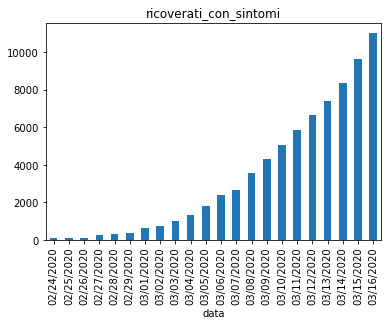

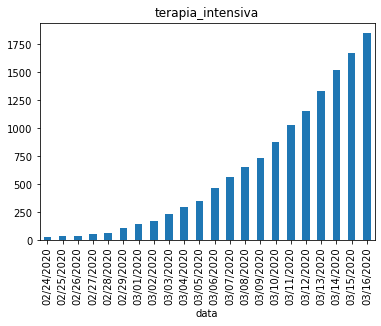

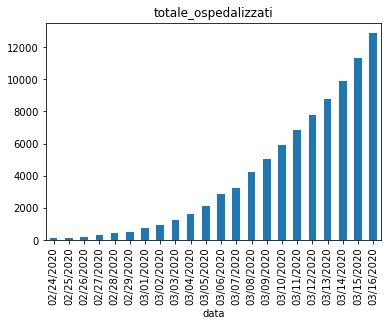

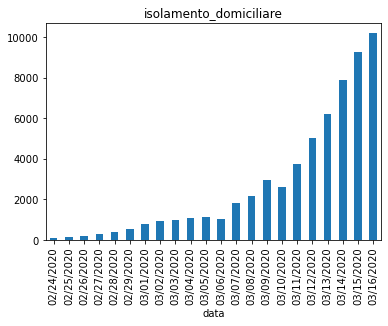

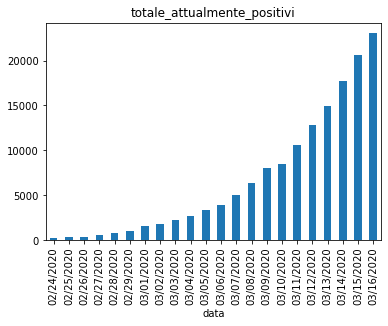

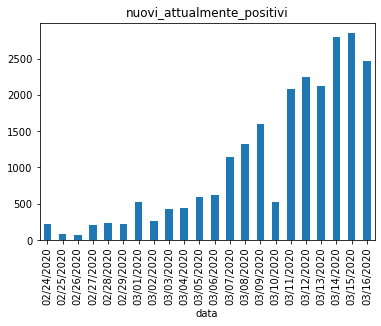

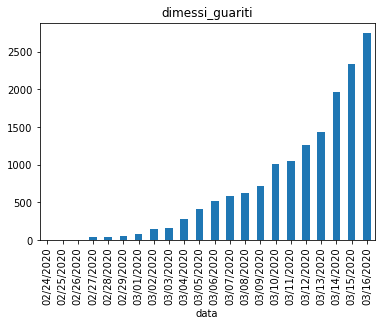

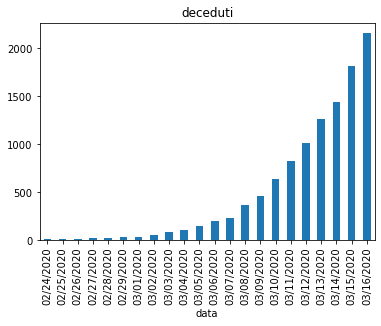

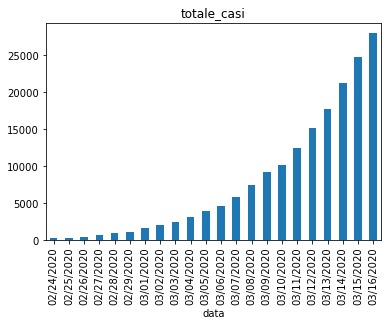

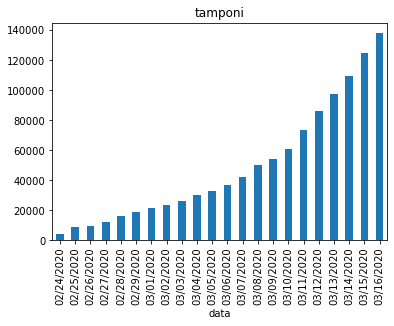

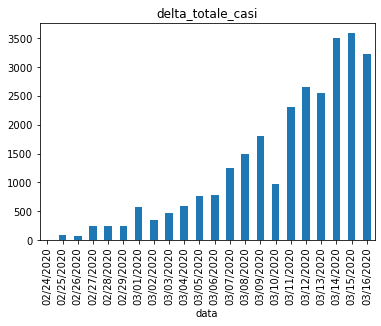

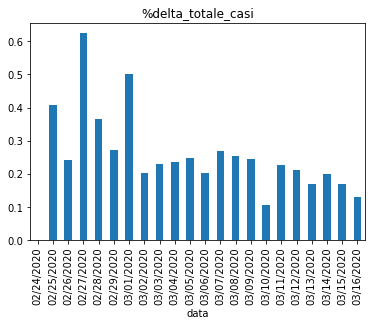

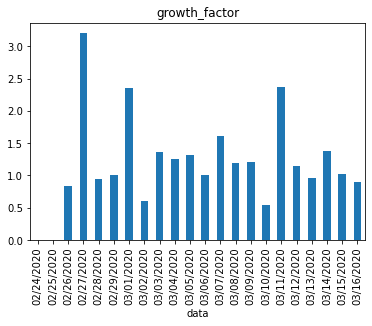

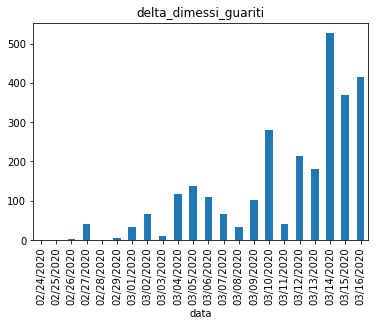

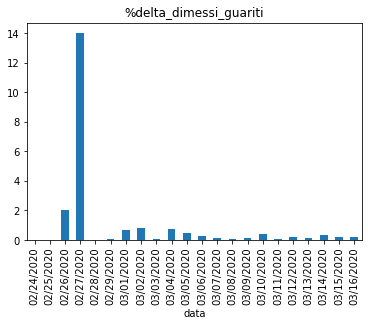

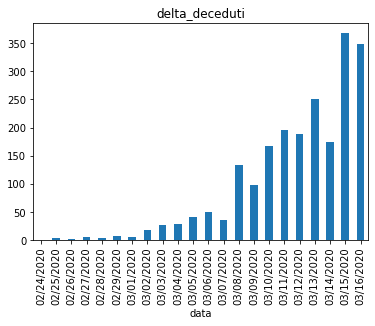

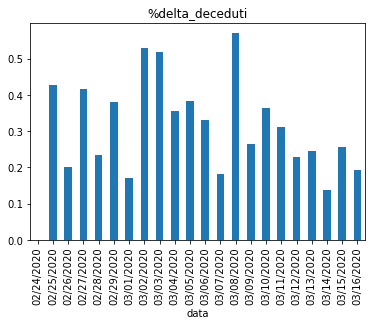

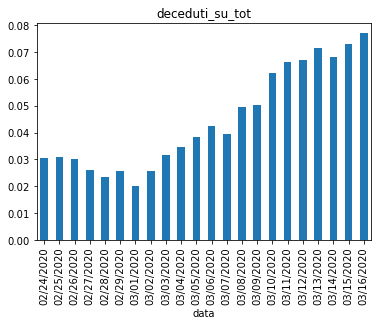

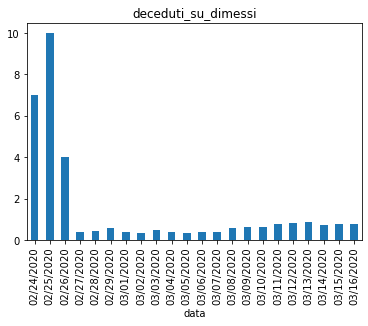

In [14]:
for col in df_naz.columns:
    plt.figure()
    df_naz[col].plot(kind='bar', title=col)    

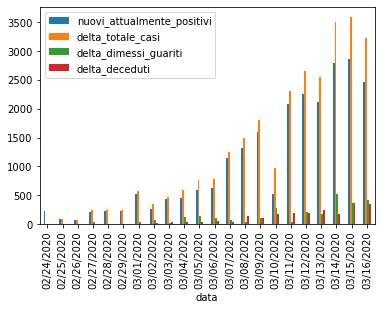

In [15]:
df_naz[['nuovi_attualmente_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].plot(kind='bar')

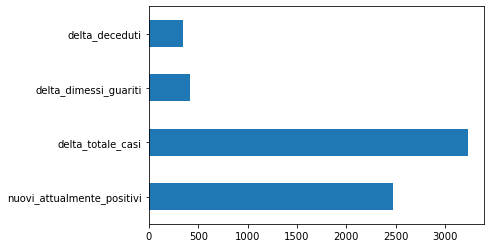

In [16]:
df_naz[['nuovi_attualmente_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].iloc[-1].plot(kind='barh')

Text(0.5, 1.0, "variazione giornaliera nuovi casi per l'Abruzzo")

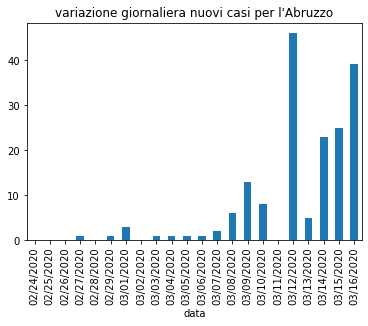

In [17]:
df_reg['Abruzzo']['delta_totale_casi'].plot(kind='bar')
plt.title("variazione giornaliera nuovi casi per l'Abruzzo")

In [86]:
from scipy.optimize import curve_fit

def func_exp(x, a, b, c):
    return np.exp(a + b * x) + c

def func_log(x, r, K, P0):
    return (K*P0*np.exp(r*x)) / (K + P0*(np.exp(x*r)-1))
col = 'deceduti'
backward_fit = 0
forward_look = 10
showlimit = True
y = df_naz[col].values
ndays = df_naz.shape[0]
x = np.linspace(1, ndays, ndays)

max_fit = len(x)
x_fit = x[-backward_fit:max_fit + 1]
y_fit = y[-backward_fit:max_fit + 1]
x_pred = np.linspace(1, ndays + forward_look, (ndays + forward_look))

popt_log, pcov_log = curve_fit(func_log, x_fit, y_fit,  bounds=([0., 0., 0.], [np.inf, np.inf, np.inf]))
popt_exp, pcov_exp = curve_fit(func_exp, x_fit, y_fit,  bounds=([0., 0., 0.], [np.inf, np.inf, np.inf]))
y_pred_log = func_log(x_pred, *popt_log)
y_pred_exp = func_exp(x_pred, *popt_exp)
#curve_fit(func_log_verhulst, x_fit, y_fit)

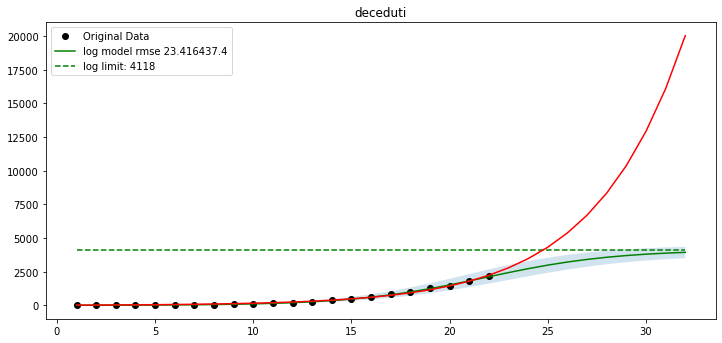

In [87]:
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.title(col)
plt.plot(x, y, 'ko', label="Original Data")

if ~np.isinf(pcov_log).max():
    log_rmse = np.sqrt(np.mean((y_fit - func_log_verhulst(x_fit, *popt_log)) ** 2))
    plt.plot(x_pred, y_pred_log, 'g-', label="log model rmse %f.4"%log_rmse)
    perr = np.sqrt(np.diag(pcov_log))
    popt_log_up = popt_log + perr
    popt_log_down = popt_log - perr
    plt.fill_between(x_pred, func_log_verhulst(x_pred, *popt_log_down), func_log_verhulst(x_pred, *popt_log_up), alpha=0.2)
loglimit = func_log_verhulst(500, *popt_log)
log_limit = np.array([loglimit for i in range(len(x_pred))])
if showlimit: plt.plot(x_pred, log_limit, 'g--', label='log limit: %i' % (loglimit))

plt.plot(x_pred, y_pred_exp, 'r-')
    
plt.legend(loc='upper left')    

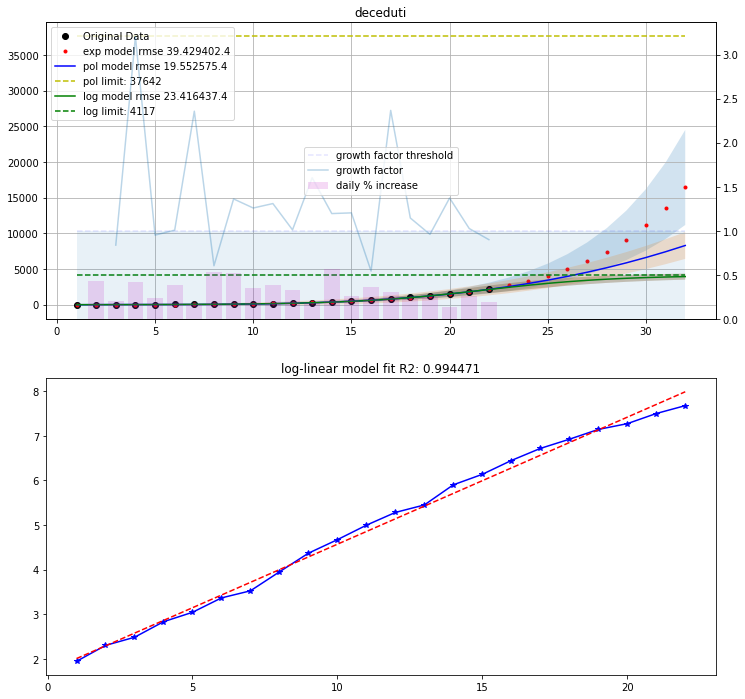

next day prediction for log model:  2436
next day prediction for exp model:  2709
next day prediction for pol model:  2534
data
03/12/2020    1016
03/13/2020    1266
03/14/2020    1441
03/15/2020    1809
03/16/2020    2158
Name: deceduti, dtype: int64


In [18]:
tools.plot_model(df_naz, 'deceduti', backward_fit=0, forward_look=10, plotlimit=True, show_pol=True)

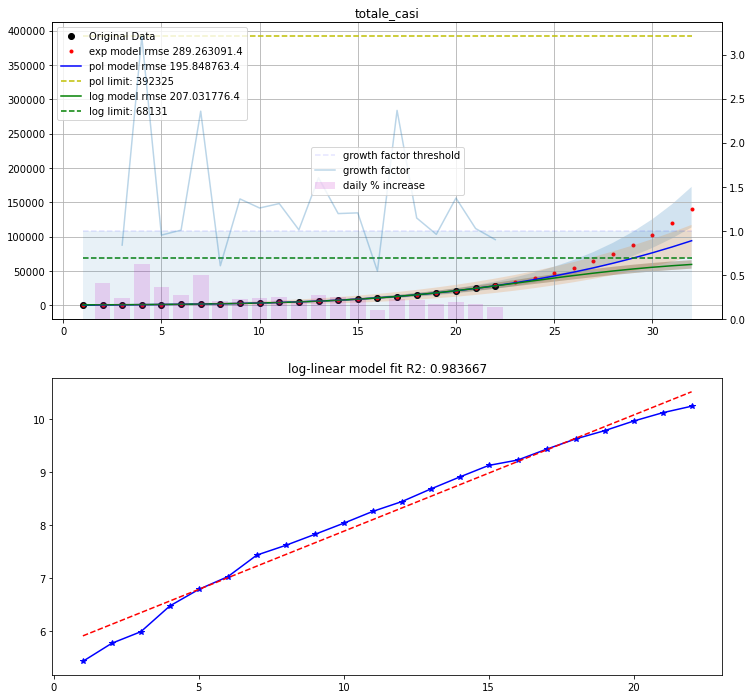

next day prediction for log model:  31869
next day prediction for exp model:  33697
next day prediction for pol model:  32532
data
03/12/2020    15113
03/13/2020    17660
03/14/2020    21157
03/15/2020    24747
03/16/2020    27980
Name: totale_casi, dtype: int64


In [19]:
tools.plot_model(df_naz.replace(0,0.01), 'totale_casi', backward_fit=-1, forward_look=10, plotlimit=True, show_log=True, show_exp=True, show_pol=True)